# BERT : 영화리뷰 감성(긍정/부정) 분석하기
- Pretrained model : Bert(Huggingface)
- TensorFlow와 Keras를 사용하여 BERT 기반의 모델을 컴파일하고 훈련
- FineTuning (사전학습모델의 파라미터를 추가적으로 학습, 일부 파라미터만 수정하거나 전체 파라미터를 모두 수정)
- Huggin Face에서 제공하는 분류를 위한 BertForSequenceClassification 클래스 사용
: 기본적인 BERT 모델에 신경망 층이 추가된 구조를 바로 사용할 수 있다. 미세 조정 방식은 데이터를 새로 학습해야 하기 때문에 정답 라벨이 있는 데이터를 학습/평가 데이터로 구분해야 한다. 새로 학습을 진행할 때 초기 파라미터는 사전학습 모델의 파라미터가 그대로 사용된다.


# Load Library & Data

In [2]:

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer, TFBertForSequenceClassification # huggingface
import warnings

warnings.filterwarnings('ignore')
df = pd.read_csv("https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv", delimiter='\t', header = None)
df.head()

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [4]:
torch.cuda.is_available() # Using GPU check

True

In [23]:
df[1] # label

0       1
1       0
2       0
3       1
4       1
       ..
6915    1
6916    0
6917    0
6918    0
6919    1
Name: 1, Length: 6920, dtype: int64

In [5]:
# load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Split Train / Test set

In [7]:
labels = df[1].values
# labels = torch.tensor(labels)

# train : test = 8 : 2
X_train, X_test, y_train, y_test = train_test_split(df[0], labels, random_state=42, test_size=0.2)


# Encoding & Tokenizing

In [9]:


def encode(data, tokenizer):
    input_ids = []
    attention_masks = []
    token_type_ids = []

    for text in data:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=50,
                                            add_special_tokens = True,
                                            pad_to_max_length=True,
                                            return_attention_mask=True,
                                              truncation=True)

        input_ids.append(tokenized_text['input_ids'])
        attention_masks.append(tokenized_text['attention_mask'])
        token_type_ids.append(tokenized_text['token_type_ids'])

    return input_ids, attention_masks, token_type_ids

In [10]:
# Train data set tokenizing
train_input_ids, train_attention_masks, train_token_type_ids = encode(X_train, tokenizer)

# Test data set tokenizing
test_input_ids, test_attention_masks, test_token_type_ids = encode(X_test, tokenizer)


In [17]:
print(train_input_ids[:2])

[[101, 8425, 3348, 2089, 2022, 2054, 1005, 1055, 15411, 9501, 2000, 4895, 7011, 8939, 3993, 1010, 2021, 13940, 4616, 2011, 4644, 1998, 16216, 2890, 2024, 2054, 2097, 2562, 2068, 8300, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 3383, 1996, 7977, 4355, 3185, 2412, 2081, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


# BERT모델 입력을 위한 형태로 처리
- BERT에 입력하기 위해서는 데이터를 딕셔너리 형태로 변경해야 한다.

In [13]:
#딕셔너리 형태로 변환해서 출력
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      }, label

 #데이터를 BERT에 넣을 수 있는 형태로 변경
def data_encode(input_ids_list, attention_mask_list, token_type_ids_list, label_list):
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list,label_list)).map(map_example_to_dict)

In [18]:
BATCH_SIZE = 32

# Encoded Train datatset
train_data_encoded = data_encode(train_input_ids, train_attention_masks, train_token_type_ids,y_train).shuffle(10000).batch(BATCH_SIZE)
# 학습/평가데이터에 대해서 별도로 데이터를 준비한다. 학습 데이터는 shuffle을 이용해서 무작위로 10000개의 데이터를 추출한다.

# Encoded Test datatset
test_data_encoded = data_encode(test_input_ids, test_attention_masks, test_token_type_ids, y_test).batch(BATCH_SIZE)



# Load Model
- Load TFBertForSequenceClassification model

In [19]:
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Use the 12-layer BERT model
    num_labels = 2,
#   output_attentions = False,
#   output_hidden_states = False
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Learning(PineTuning)
- 이제 fit()함수를 이용해서 모델 학습을 진행한다.
- validation set 으로 앞서 정의한 test_data_encoded 를 사용했다.
- epoch=10 인 경우 정확도가 0.9 정도로 향상되었음을 알 수 있다.
- epoch=30으로 학습할 경우 정확도가 0.91로 별 차이는 없다.

### 파인튜닝(Fine-tuning)
- 머신러닝과 딥러닝에서 이미 사전 훈련된(pre-trained) 모델을 특정 작업이나 데이터셋에 맞게 추가적으로 조정(추가적인 훈련)하는 과정
- 이 과정에서 모델의 가중치는 새로운 데이터에 맞게 적절히 조정되어, 특정 작업에 대한 모델의 성능이 개선
- 주로 대규모 데이터셋으로 사전 훈련된 모델을 더 작은 데이터셋이나 특정한 작업에 적용할 때 사용

In [20]:
optimizer = tf.keras.optimizers.Adam(1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
NUM_EPOCHS = 10
history = model.fit(train_data_encoded, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=test_data_encoded)

# model.fit 메서드를 사용하여 모델을 특정 데이터셋에 대해 추가적으로 훈련(파인튜닝)합니다. 이 과정에서 모델의 가중치는 새로운 데이터에 맞게 조정됩니다.

Epoch 1/10
173/173 [==============================] - 141s 381ms/step - loss: 0.4156 - accuracy: 0.8139 - val_loss: 0.2523 - val_accuracy: 0.9082
Epoch 2/10
173/173 [==============================] - 67s 384ms/step - loss: 0.2095 - accuracy: 0.9241 - val_loss: 0.2262 - val_accuracy: 0.9097
Epoch 3/10
173/173 [==============================] - 62s 358ms/step - loss: 0.1216 - accuracy: 0.9622 - val_loss: 0.2390 - val_accuracy: 0.9176
Epoch 4/10
173/173 [==============================] - 62s 360ms/step - loss: 0.0775 - accuracy: 0.9776 - val_loss: 0.2851 - val_accuracy: 0.9032
Epoch 5/10
173/173 [==============================] - 64s 367ms/step - loss: 0.0512 - accuracy: 0.9843 - val_loss: 0.3357 - val_accuracy: 0.8996
Epoch 6/10
173/173 [==============================] - 63s 363ms/step - loss: 0.0347 - accuracy: 0.9899 - val_loss: 0.2867 - val_accuracy: 0.9191
Epoch 7/10
173/173 [==============================] - 62s 358ms/step - loss: 0.0226 - accuracy: 0.9939 - val_loss: 0.3288 - val_a

 ## Code explain
 1. optimizer
 - 학습률이 1e-5인 Adam 옵티마이저를 생성
 - Adam 옵티마이저는 모델의 가중치를 업데이트하는 데 사용되며, 이 학습률은 가중치 조정의 속도를 결정
 2. loss
 - 'Sparse Categorical Crossentropy' 손실 함수를 사용합니다.
 - from_logits=True는 손실을 계산하기 전에 출력 레이어에 소프트맥스(softmax) 함수를 적용해야 함을 의미합니다. 이 손실 함수는 다중 클래스 분류 문제에 주로 사용됩니다.
 3. Metric(평가메트릭)
 - 'Sparse Categorical Accuracy' 메트릭은 모델의 정확도를 측정하는 데 사용됩니다.
 - 이 메트릭은 모델이 예측한 레이블과 실제 레이블이 얼마나 잘 일치하는지를 나타냅니다.
 4. model.compile
 - .compile 메서드는 모델을 학습하기 전에 필요한 설정을 적용합니다. 여기서는 앞서 정의한 옵티마이저, 손실 함수, 그리고 평가 메트릭을 모델에 적용합니다.

# Result EDA

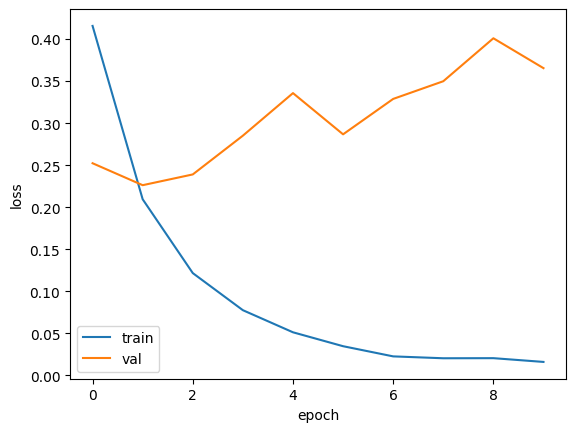

In [21]:
#loss 확인

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

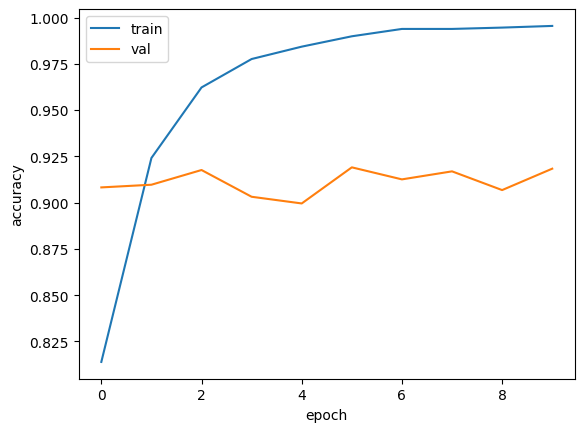

In [22]:
#정확도 확인
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()